In [66]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sys

image = Image.open("image01.jpeg")
#plt.imshow(im)
#points = plt.ginput(3, show_clicks=True)
points =[(655.5080645161289, 266.0161290322581), (182.52419354838707, 179.64516129032268), (453.9758064516128, 473.71774193548384)]

In [1]:
def rgb2lab ( inputColor ) :
    num = 0
    RGB = [0, 0, 0]
    for value in inputColor :
        value = float(value) / 255
        if value > 0.04045 :
            value = ( ( value + 0.055 ) / 1.055 ) ** 2.4
        else :
            value = value / 12.92

        RGB[num] = value * 100
        num = num + 1

    XYZ = [0, 0, 0,]

    X = RGB [0] * 0.4124 + RGB [1] * 0.3576 + RGB [2] * 0.1805
    Y = RGB [0] * 0.2126 + RGB [1] * 0.7152 + RGB [2] * 0.0722
    Z = RGB [0] * 0.0193 + RGB [1] * 0.1192 + RGB [2] * 0.9505
    XYZ[ 0 ] = round( X, 4 )
    XYZ[ 1 ] = round( Y, 4 )
    XYZ[ 2 ] = round( Z, 4 )

    XYZ[ 0 ] = float( XYZ[ 0 ] ) / 95.047         # ref_X =  95.047   Observer= 2°, Illuminant= D65
    XYZ[ 1 ] = float( XYZ[ 1 ] ) / 100.0          # ref_Y = 100.000
    XYZ[ 2 ] = float( XYZ[ 2 ] ) / 108.883        # ref_Z = 108.883

    num = 0
    for value in XYZ :
        if value > 0.008856 :
            value = value ** ( 0.3333333333333333 )
        else :
            value = ( 7.787 * value ) + ( 16 / 116 )

        XYZ[num] = value
        num = num + 1

    Lab = [0, 0, 0]

    L = ( 116 * XYZ[ 1 ] ) - 16
    a = 500 * ( XYZ[ 0 ] - XYZ[ 1 ] )
    b = 200 * ( XYZ[ 1 ] - XYZ[ 2 ] )

    Lab [ 0 ] = round( L, 4 )
    Lab [ 1 ] = round( a, 4 )
    Lab [ 2 ] = round( b, 4 )

    return Lab

In [2]:
def plotValues(data, xAxis=[], xLabel="", yLabel="",title=""):
    plt.xlabel(xLabel)
    plt.ylabel(yLabel) 
    plt.title(title) 
    if len(xAxis) > 0:
        plt.plot(xAxis, data, '-ok')
    else:
        plt.plot(data, '-ok')

In [3]:
def clusterize(centroids, data, k):
    clusters = [ [] for i in range(k)]
    labels = []
    for dataPoint in data:
        cluster_index=-1
        distance = float('inf')
        for c_index, cluster_center in enumerate(centroids):
            #print("cluster center distance", len(cluster_center))
            distance_to_center = calculateDistance(cluster_center, dataPoint)
            if distance_to_center < distance:
                distance = distance_to_center
                cluster_index = c_index
        labels.append(cluster_index)
        #clusters[cluster_index].append(np.array(dataPoint))
    return labels    

In [4]:
def calculateDistance(pointA, pointB):
    #if len(pointA) != len(pointB):
        #print(len(pointA),len(pointB))
    substract= np.subtract(pointA, pointB)
    return np.linalg.norm(substract)

In [5]:
def calculateCentroids(labels,data,k):
    #print(len(labels),len(data))
    clusters = [[] for i in range(k)]
    #print("clusters",len(clusters))
    for index,point in enumerate(data):
        clusterIndex = int(labels[index])
        clusters[clusterIndex].append(np.array(point))
    #print(np.shape(clusters[0]), np.shape(clusters[1]))
    newCentroids = []
    for cluster in clusters:
        clusterCenter = np.mean(cluster,axis=0)
        #print("cluster",len(cluster), np.shape(np.asarray(clusterCenter)))
        newCentroids.append(clusterCenter)
    return newCentroids, clusters    

In [57]:
def kMeans(kValue, data, initial_centroids):
    lossValues = []
    labels = clusterize(initial_centroids, data, kValue)
    newCentroids = initial_centroids
    stop= False
    previousLoss = float('inf')
    iteration = 0
    thresold = 0.0001
    while not stop:
        iteration += 1
        print(iteration)
        newCentroids, clusters = calculateCentroids(labels,data,kValue)
        #print("newCentroids")
        #print(newCentroids)
        labels = clusterize(newCentroids, data, kValue)
        currentLoss = 0
        for c in clusters:
            clusterVar = clusterVariance(c)
            currentLoss += clusterVar
        if(((previousLoss - currentLoss)/currentLoss) < thresold):
            stop = True
        lossValues.append(currentLoss)
        previousLoss = currentLoss
    return labels, newCentroids, lossValues

In [7]:
def clusterVariance(data):
    center = np.mean(data,axis=0)
    variance = 0
    for dataPoint in data:
        distanceSquare = np.square(calculateDistance(dataPoint, center))
        variance += distanceSquare
    return variance

In [8]:
def generateRandomCenters(k=2):
    centers = []
    for i in range(k):
        centers.append([np.random.uniform(250) for i in range(3)])
    return centers

In [22]:
def constructImageMatrix(labels, centroids, shape):
    resultNormalized = []
    for label in labels:
        resultNormalized.append(np.asarray(centroids[label]))
    return np.asarray(resultNormalized).reshape(shape)
    '''
    imageMatrix = []
    for i in shape[0]:
        matrixRow = []
        for y in shape[1]:
            normalizedIndex = (i*shape[1]) + j
            color = labels[normalizedIndex]
            matrixRow.append(np.asarray())
    '''

In [42]:
def generateImageFromMatrix(imageMatrix, file_name = 'my_result.jpeg'):
    imgResult = Image.fromarray(imageMatrix.astype(np.uint8), 'RGB')
    imgResult.save(file_name)

In [61]:
def kMeansRun(dataset, k, outfileName):
    dataNormalized = dataset.reshape((len(dataset)*len(dataset[0])),3)
    initial_centroids = generateRandomCenters(k)
    resultLabels, resultCentroids, lossValues = kMeans(k,dataNormalized, initial_centroids)
    imageMatrix = constructImageMatrix(resultLabels, resultCentroids, np.shape(dataset))
    generateImageFromMatrix(imageMatrix, file_name="k = "+str(k)+" quantized.jpeg")
    return resultLabels, lossValues

In [62]:
resultingLabels, lossData = kMeansRun(dataset, k=16,outfileName="4quantized")

1


/home/kmc/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kmc/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2
3
4
5
6
7
8
9
10


In [31]:
dataset = np.asarray(image)
k = 2

In [10]:
dataNormalized = dataset.reshape((len(dataset)*len(dataset[0])),3)
initial_centroids = generateRandomCenters(k) 
print(np.shape(dataNormalized))
print(np.shape(initial_centroids))

(520200, 3)
(2, 3)


In [11]:
resultLabels, resultCentroids, lossValues = kMeans(k,dataNormalized, initial_centroids)

1
2
3
4
5
6
7
8


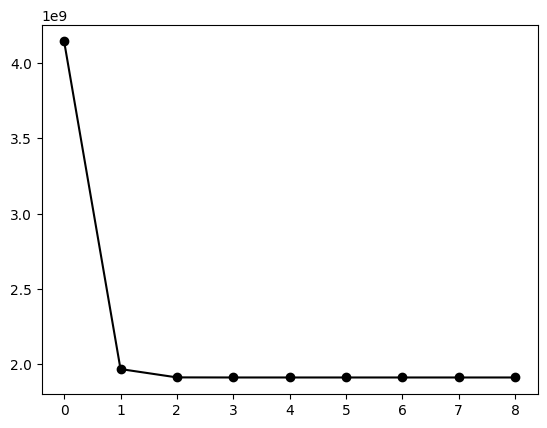

In [175]:
plotValues(lossValues)

In [23]:
imageMatrix = constructImageMatrix(resultLabels, resultCentroids, np.shape(dataset))

In [45]:
generateImageFromMatrix(imageMatrix, file_name="k = "+str(k)+" quantized.jpeg")

In [65]:
def __main__():
    k = sys.argv[1]
    fileName = sys.arv[2]
    image = Image.open(fileName)
    dataset = np.asarray(image)
    dataNormalized = dataset.reshape((len(dataset)*len(dataset[0])),3)
    initial_centroids = generateRandomCenters(k)
    resultingLabels, lossData = kMeansRun(dataset, k=16,outfileName="4quantized")